In [1]:
!pip install praw
!pip install gdown
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 8.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cti0o0k2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cti0o0k2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=33fc0ee3314425e7e6ac774bde21dcc726015c8792a1847867c2f1818c016311
  Stored in directory: /tmp/pip-ephem-wheel-cache-_jue8zxp/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import re
import csv
import json
import time
import clip
import praw
import gdown
import torch
import spacy
import requests
import torchvision

import numpy as np
import pandas as pd
import torch.nn as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F_f

from PIL import Image
from io import BytesIO
from torchvision import transforms
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.utils.data import DataLoader, TensorDataset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load data

In [3]:
# Load the data
labels = 'https://drive.google.com/file/d/169y0iMu__1O_qLaFqVPmH5eg2h01Cskc/view?usp=sharing'
data = 'https://drive.google.com/file/d/1d5hL0JgFfrUj6CnMdH3Znqt8CF8dv1tr/view?usp=sharing'

!gdown --id 169y0iMu__1O_qLaFqVPmH5eg2h01Cskc
!gdown --id 1d5hL0JgFfrUj6CnMdH3Znqt8CF8dv1tr

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=169y0iMu__1O_qLaFqVPmH5eg2h01Cskc
To: /content/labels.txt
100% 3.86k/3.86k [00:00<00:00, 12.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1d5hL0JgFfrUj6CnMdH3Znqt8CF8dv1tr
To: /content/reddit_posts_3_years.csv
100% 882k/882k [00:00<00:00, 90.8MB/s]


In [4]:
# -1 negative, 0 neutral, 1 positive
with open('/content/labels.txt', 'r') as file:
  labels = [int(line.strip()) for line in file.readlines()]

print(f"found {len(labels)} labels")

found 1718 labels


In [5]:
data = pd.read_csv("/content/reddit_posts_3_years.csv")

data.head()

,name,title,selftext,author,created_utc,score,num_comments,subreddit,link_flair_text,url
0,t3_1gneru5,Industrial Engineering at Georgia Tech,I’m planning to do Industrial engineering and ...,Passion-Creative,1.731172e+09,1,0,gatech,Question,https://www.reddit.com/r/gatech/comments/1gner...
1,t3_1gnebhg,Has anyone gone to the AAMC Medical School Fai...,Do they look for resumes and is admission open...,seamalt,1.731171e+09,1,0,gatech,Question,https://www.reddit.com/r/gatech/comments/1gneb...
2,t3_1gnbayf,Stadium seating question for today,Morning! We haven't been to a game since havin...,agatara,1.731163e+09,1,0,gatech,Question,https://www.reddit.com/r/gatech/comments/1gnba...
3,t3_1gn9p4v,Go Jackets - Beat Miami Today!,NaN,Longjumping-Ad8775,1.731158e+09,1,0,gatech,Sports,https://i.redd.it/epw2y828kvzd1.jpeg
4,t3_1gn2ma8,Gameday Announcement (Week 10 vs. Miami),# IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIITTTTTTTTT...,annoyin_ambassador,1.731128e+09,1,0,gatech,Sports,https://www.reddit.com/r/gatech/comments/1gn2m...


#Our approach

We aim to use Clip embeddings to capture the image details (when present), and use a variety of attributes like post tags, title, self text, upvotes, comments and more to generate embeddings and feed them into a custom built model to get a sentiment analysis model that generates -1, 0, 1 values corresponding to negative, neutral and positive outputs. This model and details will be uploaded to [howisgt.life](https://howisgt.life/).

Only the post text will be tokenized and converted into embeddings. The image and text embeddings will be augmented with additional signals like post flair, upvotes and comments to get a better understanding of the post's importance. For example, a post with a lot of engagement (measured by upvotes and comments) is a better indicator of campus sentiment than a post with little to no engagement.

#Data shape
**Input** => [Image embedding] + [Text embedding] + [post_score] + [num_comments] + [link_flair_text]

**Output** => [-1|0|1]

# Process data & build DataLoaders

In [6]:
def create_image_transform(target_size=(256, 256)):
  return transforms.Compose([
    transforms.Resize(target_size),
    transforms.PILToTensor()
  ])

def create_text_transform():
  return lambda x: x

image_transform = create_image_transform()
text_transform = create_text_transform()

## Helper functions

In [7]:
# clip_model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.5MiB/s]


In [8]:
# BERT model and tokenizer
bert_model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [9]:
def get_image_embedding(url):
  if url == "":
    img = Image.fromarray((torch.zeros((3, 256, 256)).numpy().astype('uint8')).transpose(1, 2, 0))
  else:
    try:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      print("found a legit image")
    except Exception as e:
      # print(f"Error retrieving image from {url}: {e}")
      # dummy image
      img = Image.fromarray((torch.zeros((3, 256, 256)).numpy().astype('uint8')).transpose(1, 2, 0))

  img_tensor = preprocess(img).unsqueeze(0).to(device)
  with torch.no_grad():
    image_embedding = clip_model.encode_image(img_tensor)

  return image_embedding.cpu().numpy()

In [10]:
def get_text_embedding(text):
  inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)
  with torch.no_grad():
    outputs = bert_model(**inputs)
    text_embedding = outputs.last_hidden_state[:, 0, :]
  return text_embedding.cpu().numpy()


In [11]:
def extract_image_urls(text):
  return re.findall(r'(https?://\S+\.(?:png|jpg|jpeg))', text)

In [12]:
# check github for code that generated this map
flair_map = {'': 0, 'Announcement': 1, 'Sports': 2, 'Social/Club': 3, 'Meta': 4, '(Misreported) News': 5, 'MEGATHREAD': 6, 'MegaThread': 7, 'Job Listing': 8, 'Photo': 9, 'YOUR MOD SPEAKS': 10, 'Meme/shitpost': 11, 'Question': 12, 'News': 13, 'Survey': 14, 'Social': 15, 'Discussion': 16, 'Rant': 17, 'Meme/Shitpost': 18, 'Other': 19, 'Survey/Study/Poll': 20}

In [13]:
def extract_attributes_and_create_embeddings():
  text_embeddings, image_embeddings, scores, num_comments, flairs = [], [], [], [], []
  entry_ctr = 0
  with open("/content/reddit_posts_3_years.csv", newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader)  # skip header row

    for row in csv_reader:
      title = row[1]
      self_text = row[2]
      text = title + " " + self_text

      text_embeddings.append(get_text_embedding(text))

      # image_urls = extract_image_urls(text)
      # if len(image_urls) == 0:
      #   image_embeddings.append(get_image_embedding(""))
      # else:
      #   image_embeddings.append(get_image_embedding(image_urls[0]))
      #   img_ctr += 1

      scores.append(float(row[5]))
      num_comments.append(int(row[6]))
      flairs.append(flair_map.get(row[8], 0))
      entry_ctr += 1
      if entry_ctr % 100 == 0:
        print(f"processed {entry_ctr}'th entry")

  text_embeddings = np.vstack(text_embeddings)
  # image_embeddings = np.vstack(image_embeddings)
  scores = np.array(scores).reshape(-1, 1)
  num_comments = np.array(num_comments).reshape(-1, 1)
  flairs = np.array(flairs).reshape(-1, 1)

  print("\n\nShape of text embeddings:", text_embeddings.shape)
  # print("Shape of image embeddings:", image_embeddings.shape)
  print("Shape of scores:", scores.shape)
  print("Shape of num_comments:", num_comments.shape)
  print("Shape of flairs:", flairs.shape)

  # all_features = np.hstack((text_embeddings, image_embeddings, scores, num_comments, flairs))
  all_features = np.hstack((text_embeddings, scores, num_comments, flairs))


  print("Shape of all features:", all_features.shape)
  print("Shape of first element in all features:", all_features[0].shape)

  return all_features


In [14]:
all_features = extract_attributes_and_create_embeddings()

processed 100'th entry
processed 200'th entry
processed 300'th entry
processed 400'th entry
processed 500'th entry
processed 600'th entry
processed 700'th entry
processed 800'th entry
processed 900'th entry
processed 1000'th entry
processed 1100'th entry
processed 1200'th entry
processed 1300'th entry
processed 1400'th entry
processed 1500'th entry
processed 1600'th entry
processed 1700'th entry


Shape of text embeddings: (1718, 768)
Shape of scores: (1718, 1)
Shape of num_comments: (1718, 1)
Shape of flairs: (1718, 1)
Shape of all features: (1718, 771)
Shape of first element in all features: (771,)


In [15]:
class redditClassificationNet(F.Module):
  def __init__(self, input_size):
    super(redditClassificationNet, self).__init__()
    self.fc1 = F.Linear(input_size, 256)
    self.fc2 = F.Linear(256, 64)
    self.fc3 = F.Linear(64, 3)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [16]:
# Add one to transform -1,0,1 -> 0,1,2
labels = (np.array(labels) + 1).astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=42)

In [18]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [31]:
input_size = X_train.shape[1]
learning_rate = 2e-4
model = redditClassificationNet(input_size).to(device)
loss_fn = F.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 55
train_losses = []
train_accuracies = []

Epoch 1/55, Loss: 0.9680, Accuracy: 54.88%
Epoch 6/55, Loss: 0.5755, Accuracy: 74.82%
Epoch 11/55, Loss: 0.4955, Accuracy: 78.60%
Epoch 16/55, Loss: 0.4346, Accuracy: 82.39%
Epoch 21/55, Loss: 0.3859, Accuracy: 83.84%
Epoch 26/55, Loss: 0.3441, Accuracy: 86.97%
Epoch 31/55, Loss: 0.2728, Accuracy: 90.47%
Epoch 36/55, Loss: 0.2213, Accuracy: 92.36%
Epoch 41/55, Loss: 0.1822, Accuracy: 93.30%
Epoch 46/55, Loss: 0.1401, Accuracy: 95.71%
Epoch 51/55, Loss: 0.1087, Accuracy: 97.67%


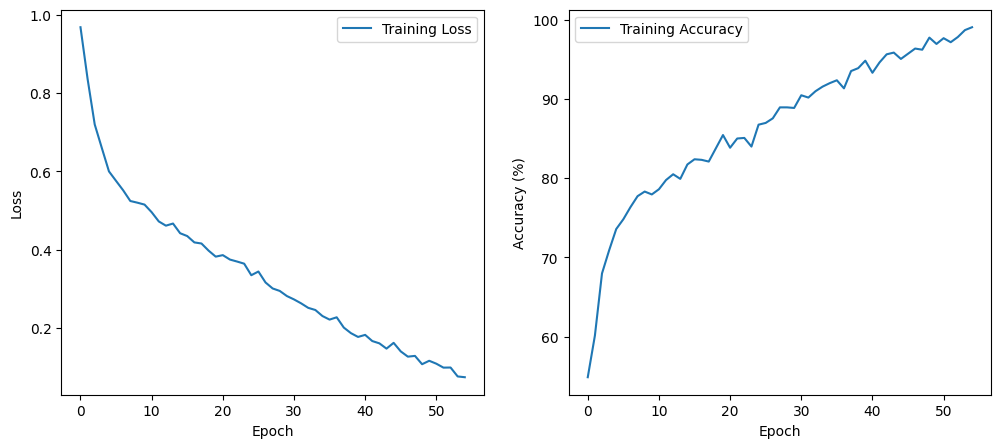

In [32]:
def train():
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      # Forward pass
      outputs = model(X_batch)
      loss = loss_fn(outputs, y_batch)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == y_batch).sum().item()
      total += y_batch.size(0)

    # Calculate accuracy and loss for the epoch
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    if epoch % 5 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%')

  # Plot training loss and accuracy
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Training Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  plt.show()

train()

In [33]:
# evaluate model
model.eval()
correct = 0
total = 0
all_preds = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 70.06%


In [34]:
torch.save(model.state_dict(), 'reddit_classifier.pth')